In [1]:
from casadi import *
from casadi.tools import *
import numpy as np
import matplotlib.pyplot as plt

# Keller's model

> In his original 1974 paper, Keller proposed a model to determine "how a runner should vary his speed $v(t)$ during a race of distance $D$ in order to run it in the shortest time". 

$$D = \int_0^T v(t) dt$$

> The velocity satisfies the equation of motion:

$$\frac{dv}{dt} + \frac{v}{\tau} = f(t)$$

> $v/\tau$ is a resistive force per unit mass, $\tau$ is a given constant, $f(t)$ is the propulsive force per unit mass, controlled by the runner. Furthermore, $\forall t \ f(t)\leq F$, where $F$ is a maximum value.  

> The force affects the quantity $E(t)$ of available oxygen in the muscles per unit mass (oxygen is consumed in reactions which release the energy used in running). Energy is used at the rate $f v$, the oxygen is supplied at a rate $\sigma$. The oxygen balance equation is:

$$\frac{d E}{d t} = \sigma - f v$$

> Eventually, Keller found $v(t)$, $f(t)$ and $E(t)$ that minimized the total running time $T$. 

> Let's use this model in our optimization problem of the rat running on a treadmill. Let's work entirely in the frame of the laboratory. 

> Taking $f$ as the control parameter, the state can be written as:

$$x = \begin{pmatrix}
x_0(t)\\
x_1(t)
\end{pmatrix}=
\begin{pmatrix}
\textrm{position}\\
\textrm{velocity}
\end{pmatrix}$$

$$\dot{x} = \begin{pmatrix}
x_1(t)\\
u - \frac{(x_1(t)-v_t)}{\tau}
\end{pmatrix}=
\begin{pmatrix}
\textrm{velocity}\\
\textrm{acceleration}
\end{pmatrix}$$

> The cost that we will minimize is:

$$E(x(t),u(t))=\int_0^T \frac{d E}{d t}=\int_0^T \left[\sigma - u\left(x_1(t) - v_t\right)\right] dt$$

> We know (from paper ***) that $v_{max}=\tau \times F$, so the only unknown parameters are $\tau$ and $\sigma$. These can be estimated using values computed for human beings. The influence of these parameters on the optimal trajectories is discussed in the following sections.

$$0.0 \leq x_0(t) \leq L_{tread}$$
$$-0.6 \leq x_1(t) \leq 0.1$$ 

The rat should only run against the treadmill with an absolute velocity $|v_{max}|=0.7$ m/s.

$$-\frac{|v_{max}|}{\tau} \leq f(t) \leq \frac{|v_{max}|}{\tau}$$

In [9]:
def biomechanical_trajectory(tau_res,sigma,x0,xf):
    '''This function takes tau and sigma from Keller's model as arguments, initial position x0
    and final position xf. It returns the optimized trajectory x0_opt, velocity x1_opt (and associated
    time array tgrid) and control u_opt (and associated time array tgrid_u)'''
    vtapis=0.1
    Ltread=0.9
    nk = 140   # Control discretization
    tf = 7.0  # End time

    # Declare variables (use scalar graph)
    t  = SX.sym("t")    # time
    u  = SX.sym("u")    # control

    states = struct_symSX([
            entry('x',shape=2),    #  vdp oscillator states
            entry('L')             #  helper state: Langrange integrand
         ])

    # Create a structure for the right hand side
    rhs = struct_SX(states)
    x = states['x']
    rhs["x"] = vertcat(x[1], u -(x[1]-vtapis)/tau_res)
    rhs["L"] = sigma - u*(x[1]-vtapis)

    # ODE right hand side function
    f = Function('f', [t,states,u],[rhs])

    # Objective function (meyer term)
    m = Function('m', [t,states,u],[states["L"]])

    # Control bounds
    u_min = -0.7/tau_res  #Fmax=vmax/tau
    u_max = -u_min
    u_init = 0.0

    u_lb = np.array([u_min])
    u_ub = np.array([u_max])
    u_init = np.array([u_init])

    # State bounds and initial guess #in the frame of the laboratory!!
    x_min =  [0., -0.6, -inf]
    x_max =  [ Ltread, 0.1,  inf]
    xi_min = [x0,  vtapis,  0.0]
    xi_max = [x0,  vtapis,  0.0]
    xf_min = [xf,  0., -inf]
    xf_max = [xf,  0.,  inf]
    x_init = [ 0.0,  0.0,  0.0]

    # Dimensions
    nx = 3
    nu = 1

    # Choose collocation points
    tau_root = [0] + collocation_points(3,"radau")

    # Degree of interpolating polynomial
    d = len(tau_root)-1

    # Size of the finite elements
    h = tf/nk

    # Coefficients of the collocation equation
    C = np.zeros((d+1,d+1))

    # Coefficients of the continuity equation
    D = np.zeros(d+1)

    # Dimensionless time inside one control interval
    tau = SX.sym("tau")

    # All collocation time points
    T = np.zeros((nk,d+1))
    for k in range(nk):
        for j in range(d+1):
            T[k,j] = h*(k + tau_root[j])

    # For all collocation points
    for j in range(d+1):
        # Construct Lagrange polynomials to get the polynomial basis at the collocation point
        L = 1
        for r in range(d+1):
            if r != j:
                L *= (tau-tau_root[r])/(tau_root[j]-tau_root[r])

        # Evaluate the polynomial at the final time to get the coefficients of the continuity equation
        lfcn = Function('lfcn', [tau],[L])
        D[j] = lfcn(1.0)

        # Evaluate the time derivative of the polynomial at all collocation points to get the coefficients of the continuity equation
        tfcn = Function('tfcn', [tau],[tangent(L,tau)])
        for r in range(d+1):
            C[j,r] = tfcn(tau_root[r])

    # Structure holding NLP variables
    V = struct_symMX([
      (
       entry("X",repeat=[nk+1,d+1],struct=states),
       entry("U",repeat=[nk],shape=nu)
      )
    ])

    vars_lb   = V()
    vars_ub   = V()
    vars_init = V()

    # Set states and its bounds
    vars_init["X",:,:] = repeated(repeated(x_init))
    vars_lb["X",:,:]   = repeated(repeated(x_min))
    vars_ub["X",:,:]   = repeated(repeated(x_max))

    # Set controls and its bounds
    vars_init["U",:] = repeated(u_init)
    vars_lb["U",:]   = repeated(u_min)
    vars_ub["U",:]   = repeated(u_max)

    # State at initial time
    vars_lb["X",0,0] = xi_min
    vars_ub["X",0,0] = xi_max

    # State at end time
    vars_lb["X",-1,0] = xf_min
    vars_ub["X",-1,0] = xf_max

    # Constraint function for the NLP
    g = []
    lbg = []
    ubg = []

    # For all finite elements
    for k in range(nk):

        # For all collocation points
        for j in range(1,d+1):

            # Get an expression for the state derivative at the collocation point
            xp_jk = 0
            for r in range (d+1):
                xp_jk += C[r,j]*V["X",k,r]

            # Add collocation equations to the NLP
            fk = f(T[k][j], V["X",k,j], V["U",k])
            g.append(h*fk - xp_jk)
            lbg.append(np.zeros(nx)) # equality constraints
            ubg.append(np.zeros(nx)) # equality constraints

        # Get an expression for the state at the end of the finite element
        xf_k = 0
        for r in range(d+1):
            xf_k += D[r]*V["X",k,r]

        # Add continuity equation to NLP
        g.append(V["X",k+1,0] - xf_k)
        lbg.append(np.zeros(nx))
        ubg.append(np.zeros(nx))

    # Concatenate constraints
    g = vertcat(*g)

    # Objective function
    f = m(T[nk-1][d],V["X",nk,0],V["U",nk-1])

    # NLP
    nlp = {'x':V, 'f':f, 'g':g}

    ## ----
    ## SOLVE THE NLP
    ## ----

    # Set options
    opts = {}
    opts["expand"] = True
    #opts["ipopt.max_iter"] = 4

    # Allocate an NLP solver
    solver = nlpsol("solver", "ipopt", nlp, opts)
    arg = {}

    # Initial condition
    arg["x0"] = vars_init

    # Bounds on x
    arg["lbx"] = vars_lb
    arg["ubx"] = vars_ub

    # Bounds on g
    arg["lbg"] = np.concatenate(lbg)
    arg["ubg"] = np.concatenate(ubg)

    # Solve the problem
    res = solver(**arg)

    # Print the optimal cost
    print("optimal cost: ", float(res["f"]))

    # Retrieve the solution
    opt = V(res["x"])

    # Get values at the beginning of each finite element
    x0_opt = opt["X",:,0,"x",0]
    x1_opt = opt["X",:,0,"x",1]
    x2_opt = opt["X",:,0,"L"]
    u_opt = opt["U",:,0]
    tgrid = np.linspace(0,tf,nk+1)
    tgrid_u = np.linspace(0,tf,nk)
    return(x0_opt,x1_opt,tgrid,u_opt,tgrid_u)

In [44]:
x0_opt,x1_opt,tgrid,u_opt,tgrid_u = biomechanical_trajectory(tau_res=0.05,sigma=8.107,x0=0.0,xf=0.0)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1680
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

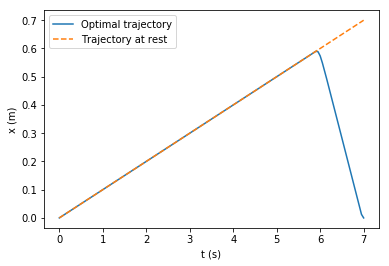

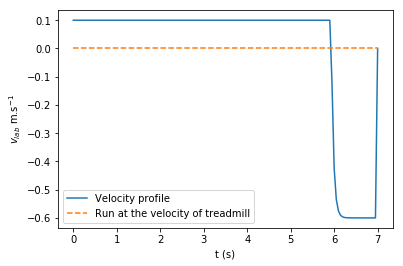

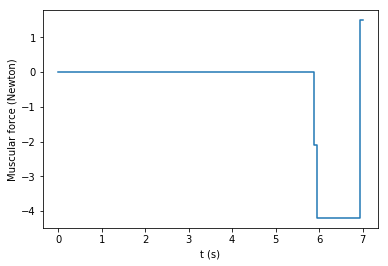

In [47]:
plt.plot(tgrid,x0_opt,label='Optimal trajectory')
plt.plot(tgrid,[0.1*t for t in tgrid],'--',label='Trajectory at rest')
plt.xlabel('t (s)')
plt.ylabel('x (m)')
plt.legend()
plt.show()

plt.plot(tgrid,x1_opt,label='Velocity profile')
plt.plot(tgrid,[0.0 for t in tgrid],'--',label='Run at the velocity of treadmill')
plt.ylabel(r'$v_{lab}$ m.s$^{-1}$')
plt.xlabel('t (s)')
plt.legend()
plt.show()

plt.step(tgrid_u,[f*0.3 for f in u_opt])
plt.ylabel('Muscular force (Newton)')
plt.xlabel('t (s)')
plt.show()

# Dependence on $\tau$

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1680
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

  14 5.2936883e+001 1.72e-002 4.07e+004  -3.8 3.62e+000  -2.1 1.00e+000 4.97e-001h  1
  15 5.2698470e+001 3.04e-002 3.51e+004  -3.8 1.74e+001  -2.6 1.27e-001 1.38e-001f  1
  16 5.2630389e+001 2.99e-002 3.45e+004  -3.8 8.88e+001  -3.0 1.00e-001 1.72e-002h  1
  17 5.2601242e+001 2.93e-002 3.39e+004  -3.8 2.50e+001  -3.5 1.72e-001 1.81e-002h  1
  18 5.2474923e+001 2.36e-002 2.73e+004  -3.8 1.41e+001  -4.0 4.42e-001 1.95e-001h  1
  19 5.2424292e+001 1.77e-002 2.04e+004  -3.8 2.73e-001  -4.5 6.32e-001 2.51e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 5.2283703e+001 3.80e-003 2.86e+003  -3.8 1.53e+000  -4.9 1.16e-001 8.60e-001h  1
  21 5.2244491e+001 1.23e-003 5.68e-004  -3.8 7.94e-001  -5.4 1.00e+000 1.00e+000h  1
  22 5.2177521e+001 5.94e-003 4.44e+003  -5.7 2.10e+000  -5.9 5.18e-001 8.17e-001f  1
  23 5.2171528e+001 2.79e-003 1.27e+003  -5.7 1.35e-001  -6.4 1.00e+000 5.33e-001h  1
  24 5.2168488e+001 1.05e-003 4.78e+002  -5.7 5.63e-002  -6

  18 5.6458377e+001 1.06e-004 4.61e+002  -5.7 2.20e-001 -12.1 4.99e-001 8.34e-001f  1
  19 5.6457474e+001 2.53e-006 7.01e-013  -5.7 3.23e-002 -12.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 5.6456699e+001 1.61e-006 5.61e+000  -8.6 2.77e-002 -13.1 9.45e-001 9.75e-001h  1
  21 5.6456679e+001 6.75e-010 4.44e-016  -8.6 5.24e-004 -13.5 1.00e+000 1.00e+000h  1
  22 5.6456678e+001 1.10e-012 4.44e-016  -9.0 1.15e-003 -14.0 1.00e+000 1.00e+000h  1

Number of Iterations....: 22

                                   (scaled)                 (unscaled)
Objective...............:  5.6456678392340400e+001   5.6456678392340400e+001
Dual infeasibility......:  4.4408920985006262e-016   4.4408920985006262e-016
Constraint violation....:  1.0975109709931985e-012   1.0975109709931985e-012
Complementarity.........:  1.0375392480121457e-009   1.0375392480121457e-009
Overall NLP error.......:  1.0375392480121457e-009   1.0375392480121457e-009




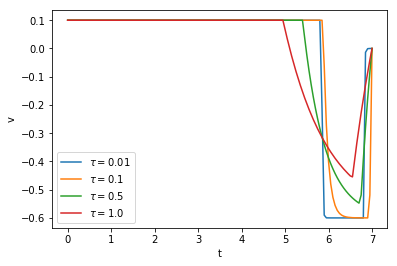

In [51]:
tauarray=[0.01,0.1,0.5,1.0]
for t in tauarray:
    x0_opt,x1_opt,tgrid,u_opt,tgrid_u = biomechanical_trajectory(tau_res=t,sigma=8.107,x0=0.0,xf=0.0)
    #plt.plot(tgrid,x0_opt,label='$\tau = $'+str(t))
    plt.plot(tgrid,x1_opt,label=r'$ \tau = $'+str(t))
plt.ylabel('v')
plt.xlabel('t')
plt.legend()
plt.show()


> Varying $\tau$ will not change the trajectory very much but changes can be observed in the velocity profile. An analysis of experimental velocity profiles should allow us to determine a good value for $\tau$. 

# Dependence on $\sigma$

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1680
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

  13 6.2796537e+001 3.11e-002 4.92e+004  -3.8 1.38e+001  -2.5 1.19e-001 1.83e-001f  1
  14 6.2541018e+001 2.55e-002 3.84e+004  -3.8 3.30e+000  -2.1 5.26e-001 2.19e-001h  1
  15 6.2211065e+001 2.47e-002 3.46e+004  -3.8 1.54e+001  -2.6 2.57e-001 9.93e-002f  1
  16 6.1931367e+001 1.87e-002 2.49e+004  -3.8 4.18e+000  -2.1 1.00e+000 2.81e-001h  1
  17 6.1830233e+001 1.82e-002 2.39e+004  -3.8 1.66e+001  -2.6 1.64e-001 3.72e-002h  1
  18 6.1728042e+001 1.61e-002 2.12e+004  -3.8 4.94e+000  -2.2 8.62e-002 1.13e-001h  1
  19 6.1551150e+001 1.50e-002 1.98e+004  -3.8 1.91e+001  -2.7 2.74e-001 6.64e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 6.1480624e+001 1.37e-002 1.80e+004  -3.8 5.66e+000  -2.2 8.64e-002 9.09e-002h  1
  21 6.1323111e+001 1.40e-002 1.67e+004  -3.8 1.85e+001  -2.7 2.67e-001 7.54e-002f  1
  22 6.1240651e+001 1.20e-002 1.43e+004  -3.8 6.02e+000  -2.3 1.28e-001 1.39e-001h  1
  23 6.1100819e+001 1.46e-002 1.29e+004  -3.8 1.89e+001  -2

  31 6.9059255e+002 5.17e-003 1.48e+003  -5.7 2.27e+000  -6.6 6.95e-001 7.95e-001f  1
  32 6.9058478e+002 2.26e-003 1.33e+003  -5.7 1.55e-001  -7.1 1.00e+000 5.64e-001h  1
  33 6.9058102e+002 8.05e-004 4.71e+002  -5.7 6.30e-002  -7.5 1.00e+000 6.46e-001f  1
  34 6.9057947e+002 1.94e-004 1.13e+002  -5.7 2.32e-002  -8.0 1.00e+000 7.60e-001f  1
  35 6.9057899e+002 5.35e-008 1.95e-011  -5.7 5.84e-003  -8.5 1.00e+000 1.00e+000f  1
  36 6.9057838e+002 3.07e-007 6.95e+001  -8.6 2.17e-002  -9.0 9.98e-001 6.21e-001f  1
  37 6.9057816e+002 1.62e-007 2.77e+001  -8.6 8.36e-003  -9.4 1.00e+000 6.03e-001f  1
  38 6.9057807e+002 6.79e-008 1.04e+001  -8.6 3.36e-003  -9.9 1.00e+000 6.23e-001f  1
  39 6.9057804e+002 2.57e-008 3.79e+000  -8.6 1.28e-003 -10.4 1.00e+000 6.37e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 6.9057802e+002 8.83e-009 1.28e+000  -8.6 4.70e-004 -10.9 1.00e+000 6.62e-001f  1
  41 6.9057802e+002 2.40e-009 3.44e-001  -8.6 1.61e-004 -11

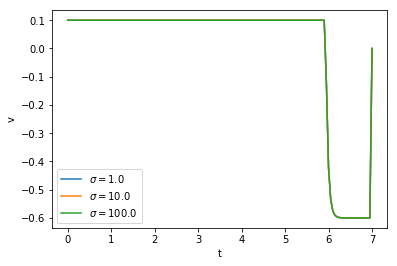

In [55]:
sigmarray=[1.0,10.0,100.0]
for s in sigmarray:
    x0_opt,x1_opt,tgrid,u_opt,tgrid_u = biomechanical_trajectory(tau_res=0.05,sigma=s,x0=0.0,xf=0.0)
    #plt.plot(tgrid,x0_opt,label=r'$\sigma = $'+str(s))
    plt.plot(tgrid,x1_opt,label=r'$ \sigma = $'+str(s))
plt.ylabel('v')
plt.xlabel('t')
plt.legend()
plt.show()


> Changing parameter $\sigma$ strongly affects the value of the final cost but has no influence on the trajectory and velocity profiles. 